<center > <img src = "https://raw.githubusercontent.com/Masterx-AI/Project_BoomBikes_Share_Prediction/main/bbk.jpg" style = "width: 700px;"/>

<a id = "table-of-contents"></a>
# Table of Contents
- [Introduction](#intro)
     - [Problem description](#background)
     - [About the data](#data)
     - [Questions](#questions)
     - [Business task](#business)
- [Import data](#import)
- [Data wrangling](#wrangling)
- [Data validation](#validation)
- [EDA 1st Q](#eda1)
- [EDA 2nd Q](#eda2)
- [Save data for modelling](#eda3)

<a id = "intro"></a>
<a id = "background"></a>
## Problems Description
I. Company believes the future success depends on maximizing the number of annual memberships. Understand how casual riders and annual members use bikes differently. Design a new marketing strategy to convert casual riders into annual members.  
II. The director of logistic gave a task to find out the places where they need to stop let bikes and the places where to reinforce the number on bikes. Investigate the GIS aspect of members and casuals. Find  "hot" points of city where we need to bring more biceclys and where to take.  
III. You've been told this year has been a disaster: almost all the bicycles are out of commission, some are under repair. We need to know the approximate number of bicycles for the next month.

<a id = "data"></a>
## About the Data
1. [Divvy Bikes](https://divvybikes.com/) is the bicycle sharing system in the Chicago metropolitan area, currently serving the cities of Chicago and Evanston. Company makes its Historical trip data available for public use. The datasets were downloaded from [link](https://divvy-tripdata.s3.amazonaws.com/index.html), under this [license](https://ride.divvybikes.com/data-license-agreement). Each trip is anonymized and includes, trip start day and time, trip end day and time, Trip start station, a Trip end station, Rider type. For this project, I will be analyzing Cyclist trip data between *January, 2021 and November, 2022*. Each month's data in a separate CSV file was loaded and were later concatinated.
2. Weather data was taken using [world weather API](https://www.worldweatheronline.com/weather-api/api/)
3. Geo data of Chicago was taken from [shape files for the boundaries of the city of Chicago](https://data.cityofchicago.org/Facilities-Geographic-Boundaries/Boundaries-City/ewy2-6yfk)

<a id = "questions"></a>
## Questions

**I.**
- How do annual members and casual riders use bikes differently?
- Why would casual riders buy annual memberships?
- How can company use digital media to influence casual riders to become members?
---
**II.**
- What are the "hot"/"cold" spots of the city?
- Are the majority of routes intercommunity or intracommunity?
----
**III.**
- What is the count of bicycles we need to prepare based on data?
- Qs from test on data...

<a id = "business"></a>
## Business Task
**Maximising the number of annual members in an effort to boost company's growth.**
- Determine the factors that influence casual riders into buying annual memberships

- Identify historical trends for casual and annual bike riders

- Use insights from historical trends and factors associated with casual riders buying annual memberships to improve the casual rider to annual membership conversion rate via digital media.

In [1]:
import os
import holidays
import pandas as pd
import numpy as np
import warnings
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import contextily as cx
import random

from math import radians, cos, sin, asin, sqrt
from shapely.geometry import Point, Polygon
from scipy import stats
from scipy.stats import boxcox,yeojohnson

warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', None)

<a id = "import"></a>
# <b><span style='color:#4797ef'>|</span> Import Data</b>

In [2]:
directory = "../data/trips/"
df_trips = pd.DataFrame()
data_filenames = [filename for filename in os.listdir(
    directory) if filename.endswith('.csv')]
for filename in data_filenames:
    trip_df = pd.read_csv(directory+filename, index_col=0)
    df_trips = df_trips.append(trip_df)

The original dataset has **10,743,239** observations and **13** features. It was then checked for consistency in column names and data types and no discrepancy was detected. After that, the data row containing missing values were dropped and outliers were removed leaving behind **5,804,937** observations.

In [3]:
df_trips.head()

,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual
ride_id,,,,,,,,,,,,
E19E6F1B8D4C42ED,electric_bike,2021-01-23 16:14:19,2021-01-23 16:24:44,California Ave & Cortez St,17660,NaN,NaN,41.900341,-87.696743,41.89,-87.72,member
DC88F20C2C55F27F,electric_bike,2021-01-27 18:43:08,2021-01-27 18:47:12,California Ave & Cortez St,17660,NaN,NaN,41.900333,-87.696707,41.90,-87.69,member
EC45C94683FE3F27,electric_bike,2021-01-21 22:35:54,2021-01-21 22:37:14,California Ave & Cortez St,17660,NaN,NaN,41.900313,-87.696643,41.90,-87.70,member
4FA453A75AE377DB,electric_bike,2021-01-07 13:31:13,2021-01-07 13:42:55,California Ave & Cortez St,17660,NaN,NaN,41.900399,-87.696662,41.92,-87.69,member
BE5E8EB4E7263A0B,electric_bike,2021-01-23 02:24:02,2021-01-23 02:24:45,California Ave & Cortez St,17660,NaN,NaN,41.900326,-87.696697,41.90,-87.70,casual


In [4]:
print(f"df_trips has {df_trips.shape[0]} observations and {df_trips.shape[1]} features")

df_trips has 10743239 observations and 12 features


In [5]:
df_weather = pd.read_csv("../data/weather/chicago.csv")
df_weather.head()

,date_time,maxtempC,mintempC,totalSnow_cm,sunHour,uvIndex,moon_illumination,moonrise,moonset,sunrise,sunset,DewPointC,FeelsLikeC,HeatIndexC,WindChillC,WindGustKmph,cloudcover,humidity,precipMM,pressure,tempC,visibility,winddirDegree,windspeedKmph,location
0,2020-04-01 00:00:00,8,3,0.0,11.9,3,55,10:45 AM,01:28 AM,05:33 AM,06:17 PM,1,-1,3,-1,20,77,88,0.0,1019,3,10,120,14,chicago
1,2020-04-01 01:00:00,8,3,0.0,11.9,3,55,10:45 AM,01:28 AM,05:33 AM,06:17 PM,1,0,3,0,20,84,89,0.0,1018,3,10,155,14,chicago
2,2020-04-01 02:00:00,8,3,0.0,11.9,3,55,10:45 AM,01:28 AM,05:33 AM,06:17 PM,2,0,3,0,19,91,89,0.0,1018,3,10,190,13,chicago
3,2020-04-01 03:00:00,8,3,0.0,11.9,3,55,10:45 AM,01:28 AM,05:33 AM,06:17 PM,2,0,3,0,18,99,90,0.0,1018,3,10,224,13,chicago
4,2020-04-01 04:00:00,8,3,0.0,11.9,3,55,10:45 AM,01:28 AM,05:33 AM,06:17 PM,2,0,3,0,18,92,90,0.0,1018,3,10,262,12,chicago


In [6]:
print(f"df_weather has {df_weather.shape[0]} observations and {df_weather.shape[1]} features")

df_weather has 23304 observations and 25 features


In [7]:
df_weather.columns

Index(['date_time', 'maxtempC', 'mintempC', 'totalSnow_cm', 'sunHour',
       'uvIndex', 'moon_illumination', 'moonrise', 'moonset', 'sunrise',
       'sunset', 'DewPointC', 'FeelsLikeC', 'HeatIndexC', 'WindChillC',
       'WindGustKmph', 'cloudcover', 'humidity', 'precipMM', 'pressure',
       'tempC', 'visibility', 'winddirDegree', 'windspeedKmph', 'location'],
      dtype='object')

In [8]:
df_weather = df_weather[["date_time", "maxtempC", "mintempC", "totalSnow_cm",
                         "FeelsLikeC", "cloudcover", "humidity", "pressure", "visibility", "windspeedKmph"]]

<a id = "wrangling"></a>
# <b><span style='color:#4797ef'>|</span> Data Wrangling</b>

In [9]:
def generate_meta_signals(df):
    meta_df = df.isna().sum().reset_index()
    meta_df['% of Total Values'] = meta_df[0]/len(df)
    meta_df = pd.concat([meta_df, pd.DataFrame(df.dtypes, columns=[
                        'dtypes']).reset_index(drop=True)], axis=1)
    d = df.describe().T.reset_index()
    meta_df = meta_df.merge(d, on=['index'], how='left')
    vcs = [pd.DataFrame(df[x].value_counts(normalize=True)).T for x in
           list(df.columns)]
    vcs = [pd.DataFrame((x.idxmax(axis=1), x.max(axis=1))).T.reset_index()
           for x in vcs if len(list(x.columns)) > 0]
    meta_df = meta_df.merge(pd.concat(vcs), on=['index'], how='left')
    meta_df.columns = ['Index', 'Missing Values', '% of Total Values', 'dtypes', 'count', 'mean',
                       'std', 'min', '25%', '50%', '75%', 'max', 'Most Frequently Value', '% of MF Values']
    return meta_df

In [10]:
def bad_flag(row):
    if row['std'] == 0:
        return True
#     elif (row['25%'] == row['50%']) and (row['50%'] == row['75%']):
#         return True
    elif row['% of Total Values'] > .15:
        return True
    elif row['% of MF Values'] > .80:
        return True
    elif pd.isnull(row['% of MF Values']):
        return True
    else:
        return False

In [11]:
meta_df = generate_meta_signals(df_trips)
    
meta_df['is Trash var'] = meta_df.apply(lambda r: bad_flag(r), axis=1)
meta_df.head(df_trips.shape[1])

,Index,Missing Values,% of Total Values,dtypes,count,mean,std,min,25%,50%,75%,max,Most Frequently Value,% of MF Values,is Trash var
0,rideable_type,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,classic_bike,0.52445,False
1,started_at,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-05-30 13:05:15,0.000001,False
2,ended_at,0,0.000000,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2022-08-22 12:47:49,0.000002,False
3,start_station_name,1442633,0.134283,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Streeter Dr & Grand Ave,0.016643,False
4,start_station_id,1442630,0.134283,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13022,0.016643,False
5,end_station_name,1546495,0.143951,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,Streeter Dr & Grand Ave,0.016911,False
6,end_station_id,1546495,0.143951,object,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,13022,0.016911,False
7,start_lat,0,0.000000,float64,10743239.0,41.901736,0.046113,41.64,41.881320,41.900000,41.929585,45.635034,41.93,0.013784,False
8,start_lng,0,0.000000,float64,10743239.0,-87.646865,0.029415,-87.84,-87.660984,-87.643206,-87.628722,-73.796477,-87.65,0.016836,False
9,end_lat,10271,0.000956,float64,10732968.0,41.902003,0.046223,41.39,41.881320,41.900000,41.930000,42.370000,41.93,0.014235,False


In [12]:
df_trips.duplicated().sum()

527

From this table we see that:
- missing values in: 'start_station_.' & 'end_station_.' & 'end_lat/ltd'
- outliers: 'ride_length'=0. This shouldn't be. The person could ordered a trip but did not take a ride.
- 'trip_duration' has negative values and the maximum values is too far from the mean. This is probably collection error whereby users input values in a wrong field
- dataset has 527 duplicates

<a id = "validation"></a>
# <b><span style='color:#4797ef'>|</span> Data Validation</b>
Steps to take
- **Dropping** the observations (rows) with missing values.
- **Dropping** duplicates.
- **Converting** date columns to date-time format.
- **Creating** new columns year, month, day_of_the_week and hour.
- **Creating** new columns trip_duration, ride_length.
- **Visualize** trip_duration, ride_length for outliers using boxplot
- **Remove** outrageous values and outliers


**Dropping** the observations (rows) with missing values.

In [13]:
if df_trips.isna().sum().sum():
    df_trips.dropna(inplace=True)

**Dropping** duplicates.

In [14]:
df_trips.drop_duplicates(inplace=True)

**Converting** date columns to date-time format.  
**Creating** new columns year, month, day_of_the_week and hour.

In [15]:
# get date of the holidays
holiday_list = []
for holiday in holidays.USA(years=[2021, 2022]).items():
    holiday_list.append(holiday[0])

In [16]:
season_dict = {1: 1,
               2: 1,
               3: 2,
               4: 2,
               5: 2,
               6: 3,
               7: 3,
               8: 3,
               9: 4,
               10: 4,
               11: 4,
               12: 1}

In [17]:
def create_time_features(df_, date_col='date_time'):
    df_[date_col] = pd.to_datetime(df_[date_col])

    df_['year'] = df_[date_col].dt.year
    df_['month'] = df_[date_col].dt.month
    df_['season'] = df_['month'].apply(lambda x: season_dict[x])
    df_['day'] = df_[date_col].dt.day
    df_['hour'] = df_[date_col].dt.hour
    df_['week_day'] = df_[date_col].dt.day_name()
    df_['is_weekend'] = np.where(
        (df_['week_day'] == "Saturday") | (df_['week_day'] == "Sunday"), 1, 0)

    df_['is_holiday'] = np.where(
        df_[date_col].dt.date.isin(holiday_list), 1, 0)
    return df_

In [18]:
df_trips = create_time_features(df_trips, 'started_at')

**Creating** a new columns trip_duration, ride_length.

In [19]:
def haversine(lon1, lat1, lon2, lat2):
    """
    Calculate the great circle distance in kilometers between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])

    # haversine formula
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a))
    # Radius of earth in kilometers. Use 3956 for miles. Determines return value units.
    r = 6371
    return c * r

In [20]:
df_trips['ended_at'] = pd.to_datetime(df_trips['ended_at'])
df_trips['trip_duration'] = df_trips.apply(lambda x: (
    x['ended_at'] - x['started_at']).total_seconds(), axis=1)
df_trips['ride_length'] = df_trips.apply(lambda x: haversine(
    x['start_lat'], x['start_lng'], x['end_lat'], x['end_lng']), axis=1)

df_trips.drop(['started_at', 'ended_at'], inplace=True, axis=1)

In [21]:
df_weather = create_time_features(df_weather, 'date_time')

From this table we see that:
- missing values in: 'start_station_.' & 'end_station_.' & 'ride_length'
- outliers: 'ride_length'=0. This shouldn't be. The person could ordered a trip but did not take a ride.
- 'trip_duration' has negative values and the maximum values is too far from the mean. This is probably collection error whereby users input values in a wrong field
- dataset doesn't have trash variables.

In [22]:
df_trips = df_trips.merge(df_weather, on=[
    'year', 'month', 'season', 'day', 'hour', 'week_day', 'is_weekend', 'is_holiday'])

In [23]:
df_trips.head()

,rideable_type,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,start_lng,end_lat,end_lng,member_casual,year,month,season,day,hour,week_day,is_weekend,is_holiday,trip_duration,ride_length,date_time,maxtempC,mintempC,totalSnow_cm,FeelsLikeC,cloudcover,humidity,pressure,visibility,windspeedKmph
0,classic_bike,California Ave & Cortez St,17660,Wood St & Augusta Blvd,657,41.900363,-87.696704,41.899181,-87.672200,member,2021,1,1,24,19,Sunday,1,0,433.0,2.724726,2021-01-24 19:00:00,0,-4,3.1,-2,100,81,1017,10,5
1,classic_bike,Sedgwick St & North Ave,TA1307000038,Stockton Dr & Wrightwood Ave,13276,41.911386,-87.638677,41.931320,-87.638742,casual,2021,1,1,24,19,Sunday,1,0,815.0,0.091609,2021-01-24 19:00:00,0,-4,3.1,-2,100,81,1017,10,5
2,classic_bike,Sedgwick St & North Ave,TA1307000038,Stockton Dr & Wrightwood Ave,13276,41.911386,-87.638677,41.931320,-87.638742,casual,2021,1,1,24,19,Sunday,1,0,761.0,0.091609,2021-01-24 19:00:00,0,-4,3.1,-2,100,81,1017,10,5
3,classic_bike,Clark St & Berwyn Ave,KA1504000146,Winchester Ave & Elston Ave,KA1504000140,41.977997,-87.668047,41.924091,-87.676460,member,2021,1,1,24,19,Sunday,1,0,1907.0,0.966639,2021-01-24 19:00:00,0,-4,3.1,-2,100,81,1017,10,5
4,classic_bike,Pulaski Rd & Eddy St (Temp),KA1504000141,Broadway & Waveland Ave,13325,41.946264,-87.731023,41.949074,-87.648636,member,2021,1,1,24,19,Sunday,1,0,1377.0,9.161025,2021-01-24 19:00:00,0,-4,3.1,-2,100,81,1017,10,5


**Visualize** numerical/continous variables for outliers using boxplot

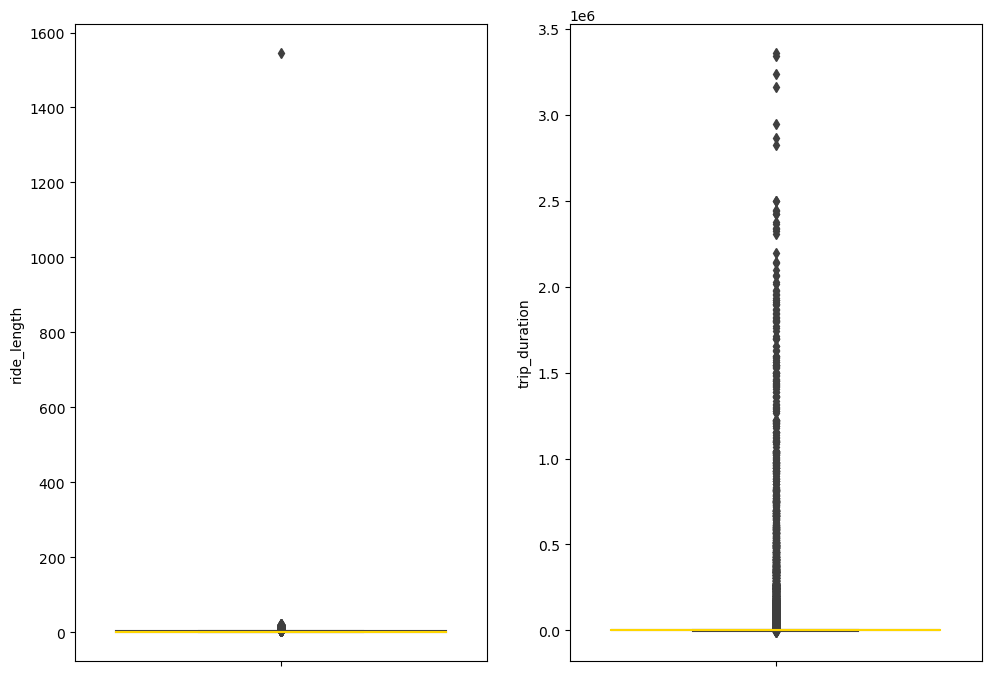

In [24]:
# visualize outliers using boxplot
fig, axs = plt.subplots(figsize=(11.7, 8.27), ncols=2)
sns.boxplot(
    data=df_trips, y="ride_length",
    color="#0183d1",
    medianprops={"color": "#ffd600"},
    ax=axs[0]
)

sns.boxplot(
    data=df_trips, y="trip_duration",
    color="#0183d1",
    medianprops={"color": "#ffd600"},
    ax=axs[1]
)

plt.savefig("../imgs/box_plot_before.png", transparent=True)

**Remove** outrageous values and outliers

In [25]:
# calculate the percentiles
ride_length_p_10 = np.percentile(df_trips["ride_length"], 10)
ride_length_p_90 = np.percentile(df_trips["ride_length"], 90)
trip_duration_p_10 = np.percentile(df_trips["trip_duration"], 10)
trip_duration_p_90 = np.percentile(df_trips["trip_duration"], 90)
df_trips = df_trips[(df_trips["ride_length"] > ride_length_p_10) &
                    (df_trips["ride_length"] < ride_length_p_90) &
                    (df_trips["trip_duration"] > trip_duration_p_10) &
                    (df_trips["trip_duration"] < trip_duration_p_90)]

In [26]:
df_trips.reset_index(drop=True, inplace=True)

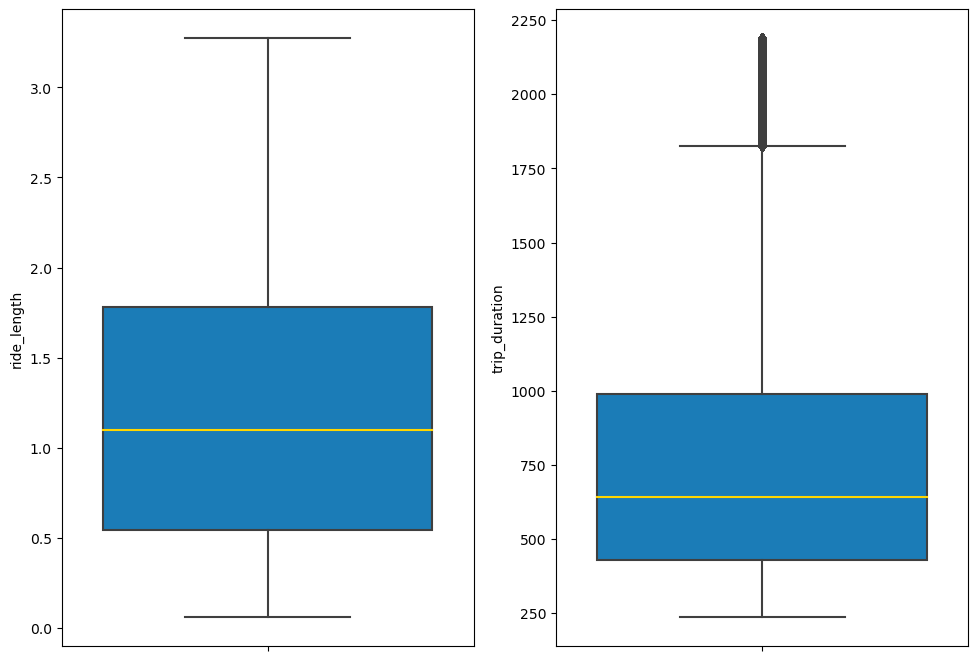

In [27]:
fig, axs = plt.subplots(figsize=(11.7, 8.27), ncols=2)
sns.boxplot(
    data=df_trips, y="ride_length",
    color="#0183d1",
    medianprops={"color": "#ffd600"},
    ax=axs[0]
)

sns.boxplot(
    data=df_trips, y="trip_duration",
    color="#0183d1",
    medianprops={"color": "#ffd600"},
    ax=axs[1]
)

plt.savefig("../imgs/box_plot_after.png", transparent=True)

In [28]:
df_trips["ride_length"].corr(df_trips["trip_duration"])

0.22681039920813528

<a id = "eda1"></a>
# <b><span style='color:#4797ef'>|</span> EDA | I Find differences & commons of riders</b>

In [30]:
def htResult(p_value):
    significance_level = 0.05
    if p_value <= significance_level:
        print('Reject Null Hypothesis')
    else:
        print('Fail to Reject Null Hypothesis')

In [31]:
df_trips_b1 = df_trips[['rideable_type', 'start_station_name', 'end_station_name', 'member_casual',
                       'ride_length', 'trip_duration', 'hour', "week_day", "day", "month", "year"]]

## Questions:
- Which bike is the most preferred bike?
- Are short rides most common or long rides?
- What is the correlation between ride length and duration of ride?

In [32]:
pd.set_option('float_format', '{:f}'.format)

In [33]:
df_trips_b1[["ride_length", "trip_duration"]].describe()

,ride_length,trip_duration
count,5804567.000000,5804567.000000
mean,1.231778,768.042166
std,0.819632,440.960141
min,0.059983,237.000000
25%,0.545005,430.000000
50%,1.100653,641.000000
75%,1.780495,988.000000
max,3.272324,2189.000000


In [34]:
df_trips_b1["rideable_type"].value_counts()

classic_bike     3924590
electric_bike    1655877
docked_bike       224100
Name: rideable_type, dtype: int64

In [35]:
df_trips_b1["member_casual"].value_counts()

member    3439545
casual    2365022
Name: member_casual, dtype: int64

In [36]:
df_trips_b1.groupby(["member_casual", "rideable_type"]).agg(
    count_col=pd.NamedAgg(column="hour", aggfunc="count")
)

count_col
member_casual rideable_type           
casual        classic_bike     1396364
              docked_bike       224100
              electric_bike     744558
member        classic_bike     2528226
              electric_bike     911319

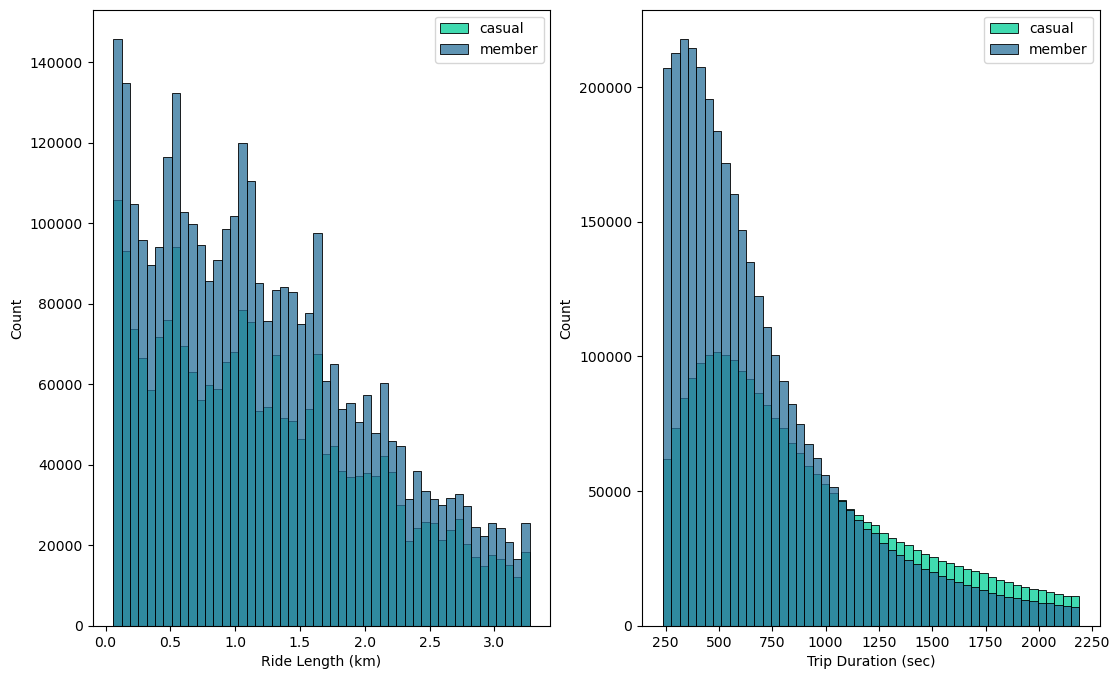

In [37]:
fig, axs = plt.subplots(figsize=(13, 8), ncols=2)
sns.histplot(df_trips_b1[df_trips_b1["member_casual"] == "casual"]
             ["ride_length"], bins=50, color="#00ce96", ax=axs[0])
sns.histplot(df_trips_b1[df_trips_b1["member_casual"] == "member"]
             ["ride_length"], bins=50, color="#2a709a", ax=axs[0])

axs[0].set_xlabel("Ride Length (km)")
axs[0].legend(["casual", "member"])

sns.histplot(df_trips_b1[df_trips_b1["member_casual"] == "casual"]
             ["trip_duration"], bins=50, color="#00ce96", ax=axs[1])
sns.histplot(df_trips_b1[df_trips_b1["member_casual"] == "member"]
             ["trip_duration"], bins=50, color="#2a709a", ax=axs[1])

axs[1].set_xlabel("Trip Duration (sec)")
axs[1].legend(["casual", "member"])

plt.savefig("../imgs/dist_rl+td.png", transparent=True)

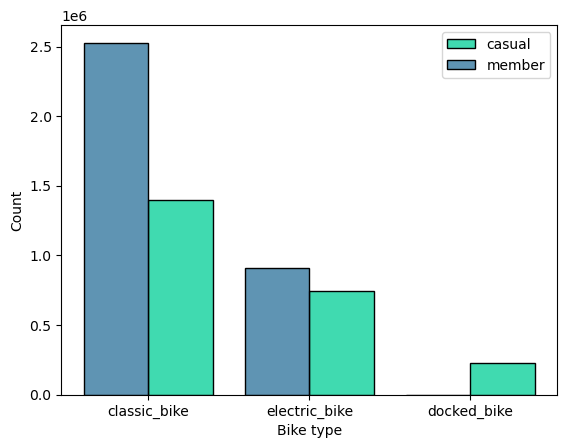

In [38]:
sns.histplot(data=df_trips_b1,
             x="rideable_type",
             hue="member_casual",
             multiple="dodge",
             shrink=.8,
             palette=["#2a709a", "#00ce96"])
plt.xlabel("Bike type")
plt.legend(["casual", "member"])
plt.savefig("../imgs/bike_type.png", transparent=True)

### Observations
- For both duration and ride_length, the median is close to mean, that is, positively skewed. This implies that:
    - Most of the rides are short in distance and time
    - Both variable are positively correlated
- Classic bike is most preferred bike by member and casual riders

a. Members
- **Classic bikes** highly prefered among Bike Share members.
- **No** rides were recorded for the docked bike

b. Casual

- Casual riders preferred **classic bikes**.
- **Least** preferred type among the casual riders were the **docked bikes**.
### Interpretation
Focusing on maximizing the number of annual memberships will most likely improve Chicago-Divvy's future success and they should also look into investing on clasic bike than the other two.

## Question: Group by member_casual and month,
- What is the average ride length and duration for every month?
- How many rides are recorded by each month?

In [39]:
trips_by_month = df_trips_b1.groupby(["month", "member_casual"]) \
    .agg({"start_station_name": 'size', "trip_duration": 'mean', "ride_length": 'mean'}) \
    .rename(columns={'start_station_name': 'number_of_rides', 'trip_duration': 'avg_duration', 'ride_length': 'avg_distance'}) \
    .reset_index()
trips_by_month

,month,member_casual,number_of_rides,avg_duration,avg_distance
0,1,casual,18745,739.581808,1.163209
1,1,member,97286,629.115495,1.157653
2,2,casual,15505,785.053789,1.174984
3,2,member,76608,644.019685,1.164445
4,3,casual,84763,894.118554,1.208407
5,3,member,196368,679.769794,1.212079
6,4,casual,128377,887.968857,1.232197
7,4,member,252035,689.305600,1.216030
8,5,casual,262678,926.344863,1.242629
9,5,member,363210,724.988123,1.233149


In [40]:
weather_by_month = df_trips.groupby(["month", "member_casual"]) \
    .agg({"FeelsLikeC": 'mean'}) \
    .rename(columns={'FeelsLikeC': 'avg_temperature'}) \
    .reset_index()
weather_by_month

,month,member_casual,avg_temperature
0,1,casual,-7.176794
1,1,member,-7.953724
2,2,casual,-6.034698
3,2,member,-7.714273
4,3,casual,5.068568
5,3,member,3.400473
6,4,casual,9.205013
7,4,member,7.849152
8,5,casual,17.646552
9,5,member,16.562333


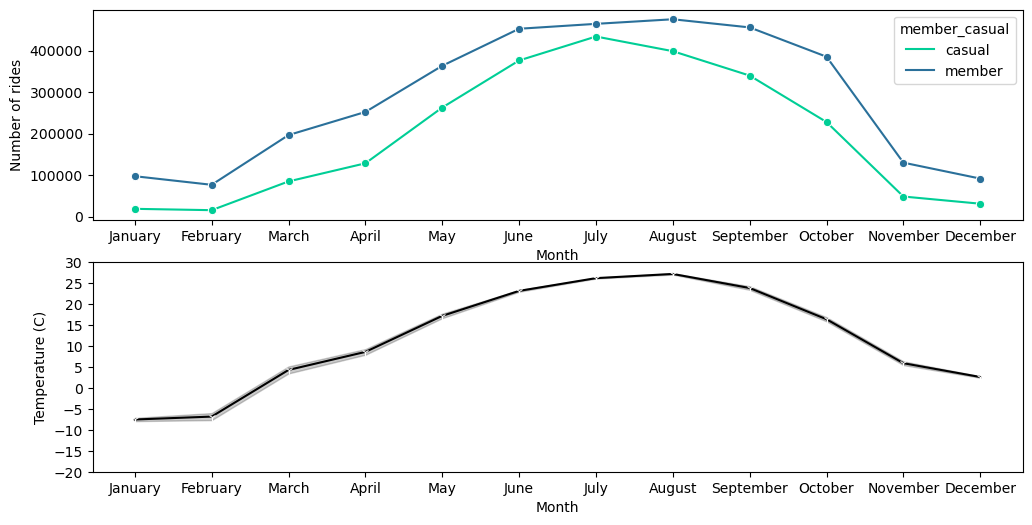

In [41]:
fig, axs = plt.subplots(figsize=(12, 6), nrows=2)
sns.lineplot(data=trips_by_month,
             x="month",
             y="number_of_rides",
             hue="member_casual",
             marker='o',
             palette=["#00ce96", "#2a709a"],
             ax=axs[0])
axs[0].set_xticks(range(1, 13),
                  labels=['January', 'February', 'March', 'April', 'May', 'June',
                          'July', 'August', 'September', 'October', 'November', 'December'])
axs[0].set_xlabel("Month")
axs[0].set_ylabel("Number of rides")

sns.lineplot(data=weather_by_month,
             x="month",
             y="avg_temperature",
             marker='1',
             color="#000000",
             ax=axs[1])
axs[1].set_xticks(range(1, 13),
                  labels=['January', 'February', 'March', 'April', 'May', 'June',
                          'July', 'August', 'September', 'October', 'November', 'December'])
axs[1].set_yticks(range(-20, 35, 5), )
axs[1].set_xlabel("Month")
axs[1].set_ylabel("Temperature (C)")

plt.savefig("../imgs/month_num_of_rides.png", transparent=True)

### Hypothesis testing: check if number_of_rides is dependent on the season.

Null hypothesis, H0 : number_of_rides is not dependant on the season.

Alternate hypothesis, Ha : number_of_rides is dependant on the season.

In [42]:
df_trips_hyp = df_trips.groupby(["is_holiday", "year", "season", "month", "hour", "day", "week_day"]) \
    .agg({"start_station_name": 'size'}) \
    .rename(columns={'start_station_name': 'number_of_rides'}) \
    .reset_index()
df_trips_hyp

,is_holiday,year,season,month,hour,day,week_day,number_of_rides
0,0,2021,1,1,0,2,Saturday,5
1,0,2021,1,1,0,3,Sunday,20
2,0,2021,1,1,0,4,Monday,6
3,0,2021,1,1,0,5,Tuesday,8
4,0,2021,1,1,0,6,Wednesday,6
...,...,...,...,...,...,...,...,...
16000,1,2022,4,10,19,10,Monday,624
16001,1,2022,4,10,20,10,Monday,413
16002,1,2022,4,10,21,10,Monday,304
16003,1,2022,4,10,22,10,Monday,202


In [43]:
cont = pd.crosstab(df_trips_hyp['number_of_rides'], df_trips_hyp['season'])
cont

season,1,2,3,4
number_of_rides,,,,
1,81,10,1,3
2,90,23,0,1
3,98,33,1,6
4,66,37,2,8
5,82,41,3,10
...,...,...,...,...
1907,0,0,1,0
1909,0,0,1,0
1914,0,0,1,0


In [44]:
c, p, dof, expected = stats.chi2_contingency(cont)

In [45]:
htResult(p)

Reject Null Hypothesis


#### Answer: We reject Null Hypothesis, which means number_of_rides is dependant on the season

### Hypothesis testing: check if No. of cycles rented is similar or different in different season.

Null hypothesis, H0 : No. of cycles rented is similar across various season.

Alternate hypothesis, Ha : No. of cycles rented is different across various season.

In [46]:
seasons = [df_trips_hyp[df_trips_hyp['season'] == i]
           ['number_of_rides'].sample(3000) for i in range(1, 5)]

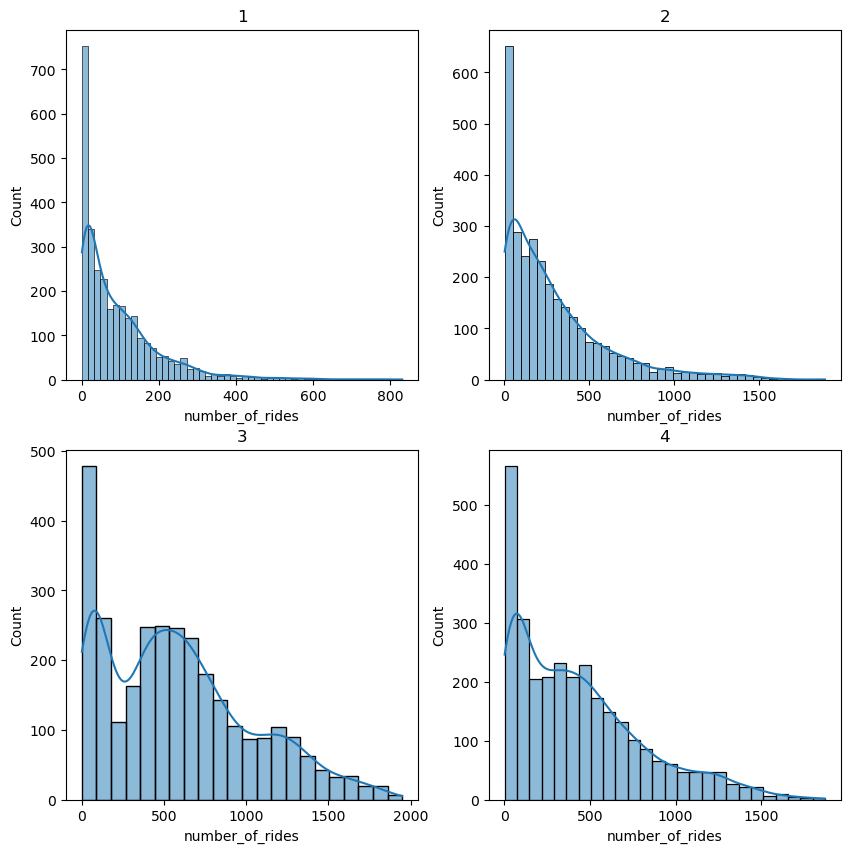

In [47]:
k = 0
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
for i in range(0, 2):
    for j in range(0, 2):
        sns.histplot(seasons[k], kde=True, ax=ax[i, j])
        ax[i, j].set_title(label=k+1)
        k += 1
plt.show()

In [48]:
p_value = stats.kruskal(seasons[0], seasons[1],
                        seasons[2], seasons[3])[1]
print("P-Value : ", p_value)

P-Value :  0.0


In [49]:
htResult(p_value)

Reject Null Hypothesis


#### Answer: We reject Null Hypothesis, which means No. of cycles rented is different across various seasons.

### Observation
- **Highest** number of rides recorded in the months of ***June***, ***July***, ***August*** and ***September*** for both riders.
- **Lowest** number of rides recorded in the months of ***November***, ***December***, ***January*** and ***February***.

Members annual total rides is more than casual riders. There is upward trend from the beginning of the year until around July and August when members and casual riders, respectively, reached the ceiling ride. They both decreases till December

### Interpretation:
Hot weather in Chicago is between May and September. At this same period, precipation reduces. It is safe to conclude that the product will serve customer more during summer season (May - September).

## Question: Group by member_casual and week days
- What is the average ride length and duration for every week day?
- How many rides are recorded by everyday?

In [50]:
trips_by_week_day = df_trips_b1.groupby(["week_day", "member_casual"]) \
    .agg({"start_station_name": 'size', "trip_duration": 'mean', "ride_length": 'mean'}) \
    .rename(columns={'start_station_name': 'number_of_rides', 'trip_duration': 'avg_duration', 'ride_length': 'avg_distance'}) \
    .reset_index()
trips_by_week_day

,week_day,member_casual,number_of_rides,avg_duration,avg_distance
0,Friday,casual,347271,854.458420,1.233033
1,Friday,member,488722,686.579753,1.225431
2,Monday,casual,266977,865.428782,1.214022
3,Monday,member,479289,678.150337,1.220101
4,Saturday,casual,512663,936.805008,1.258438
5,Saturday,member,471136,751.715522,1.242636
6,Sunday,casual,416242,939.553817,1.246093
7,Sunday,member,405927,751.684825,1.232628
8,Thursday,casual,292193,810.685759,1.238240
9,Thursday,member,524183,673.829315,1.223823


In [51]:
order = ["Monday", "Tuesday", "Wednesday", "Thursday", "Friday", "Saturday", "Sunday"]

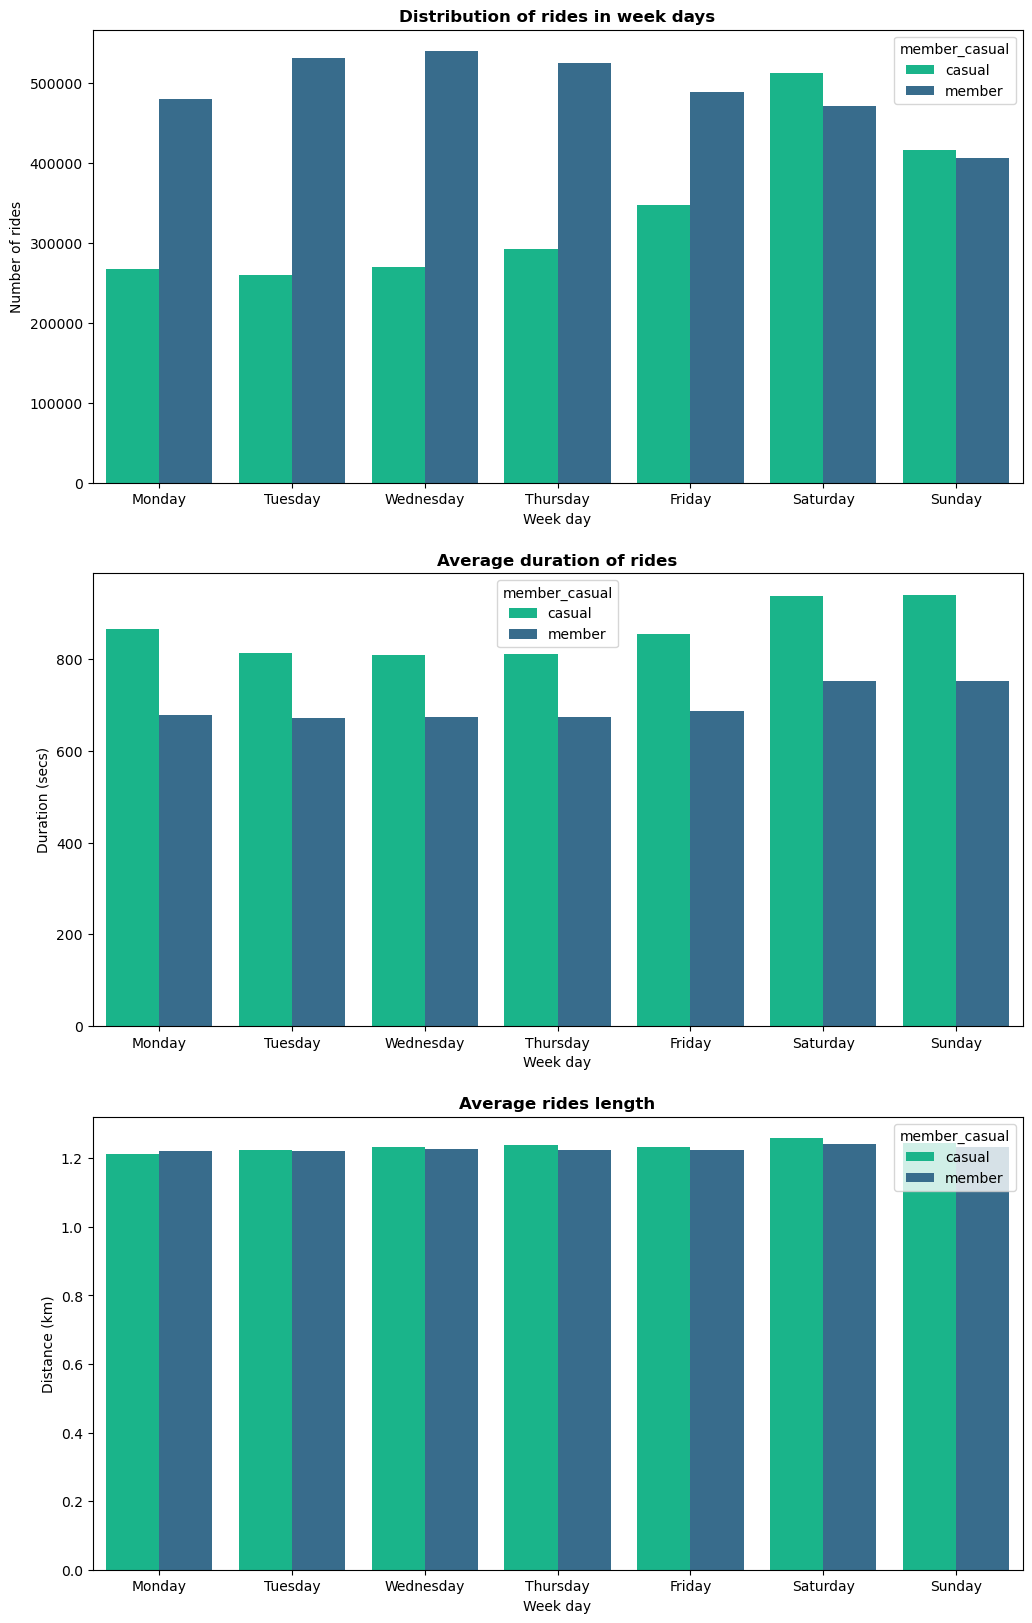

In [52]:
fig, axs = plt.subplots(figsize=(12, 20), nrows=3)
sns.barplot(data=trips_by_week_day,
            x="week_day",
            y="number_of_rides",
            hue="member_casual",
            palette=["#00ce96", "#2a709a"],
            order=order,
            ax=axs[0])
axs[0].set_title("Distribution of rides in week days",
                 fontweight="bold")
axs[0].set_xlabel("Week day")
axs[0].set_ylabel("Number of rides")

sns.barplot(data=trips_by_week_day,
            x="week_day",
            y="avg_duration",
            hue="member_casual",
            palette=["#00ce96", "#2a709a"],
            order=order,
            ax=axs[1])
axs[1].set_title("Average duration of rides",
                 fontweight="bold")
axs[1].set_xlabel("Week day")
axs[1].set_ylabel("Duration (secs)")

sns.barplot(data=trips_by_week_day,
            x="week_day",
            y="avg_distance",
            hue="member_casual",
            palette=["#00ce96", "#2a709a"],
            order=order,
            ax=axs[2])
axs[2].set_title("Average rides length",
                 fontweight="bold")
axs[2].set_xlabel("Week day")
axs[2].set_ylabel("Distance (km)")

plt.savefig("../imgs/weekday_stats.png", transparent=True)

### Hypothesis testing: does holiday has an effect on the number of  cycles rented?

Null hypothesis, H0 : There is no effect of holiday on cycles rented.

Alternate hypothesis, Ha : There is some effect of holiday on cycles rented.

In [53]:
working = df_trips_hyp[df_trips_hyp['is_holiday']==0]
not_working = df_trips_hyp[df_trips_hyp['is_holiday']==1]

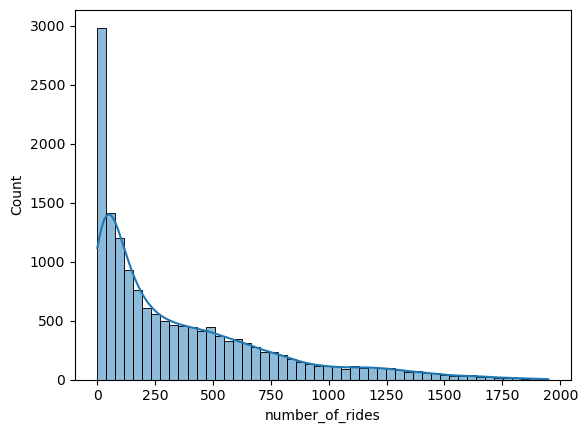

In [54]:
sns.histplot(x='number_of_rides', data=working, kde = True)
plt.show()

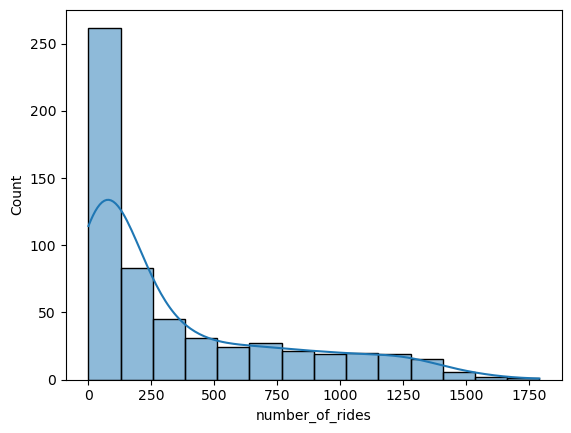

In [55]:
sns.histplot(x='number_of_rides', data=not_working, kde = True)
plt.show()

From the above graphs we can say that distribution of data looks like exponential

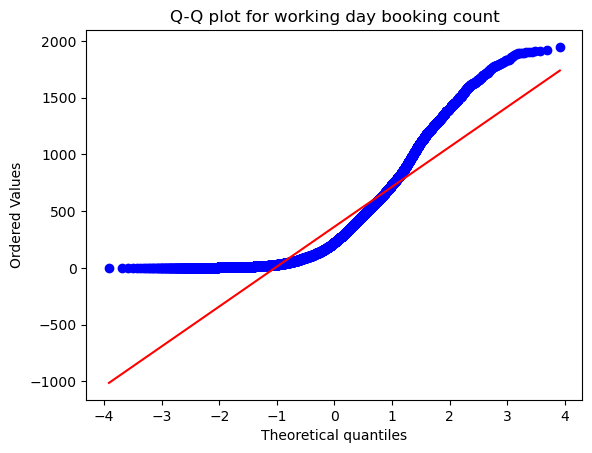

In [56]:
stats.probplot(working['number_of_rides'], plot=plt, dist="norm")
plt.title('Q-Q plot for working day booking count')
plt.show()

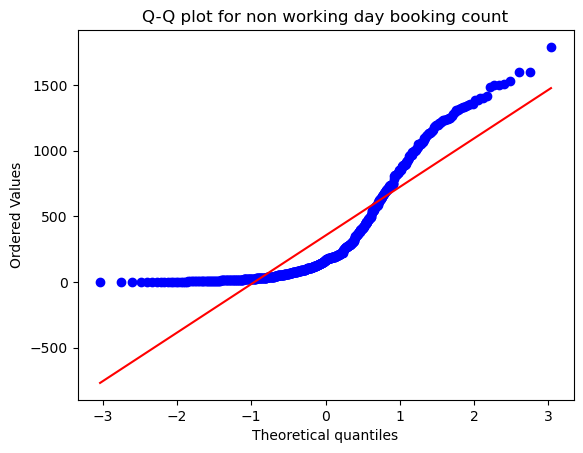

In [57]:
stats.probplot(not_working['number_of_rides'], plot= plt, dist="norm")
plt.title('Q-Q plot for non working day booking count')
plt.show()

**From both the Q-Q Plot we can say that the values are not near normal**

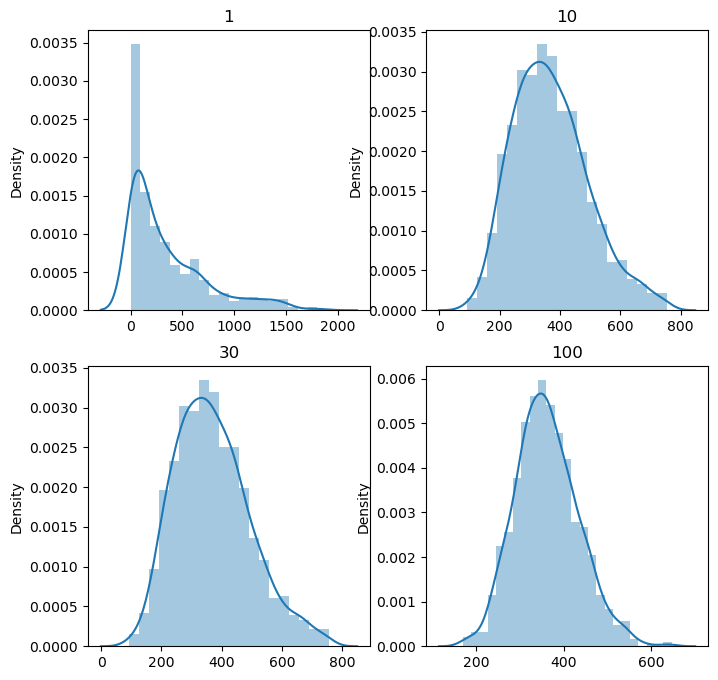

In [58]:
nums = [1, 10, 30, 100]
# list of sample means
means = []
# Generating 1, 10, 30, 100 random numbers
# taking their mean and appending it to list means.
for num in nums:
    mean_vec = [np.mean(random.sample(list(working['number_of_rides']), k=num))
                for _i in range(1000)]
    means.append(mean_vec)

k = 0
# plotting all the means in one figure
fig, ax = plt.subplots(2, 2, figsize=(8, 8))
for i in range(0, 2):
    for j in range(0, 2):
        # Histogram for each x stored in means
        sns.distplot(means[i+j], ax=ax[i, j])
        ax[i, j].set_title(label=nums[k])
        k += 1
plt.show()

So, in not very small samples (from 15 observations) the t-criterion is relatively stable to the non-normal distribution of initial data. Most of all the t-criterion is "afraid" of outliers, i.e. abnormal deviations that's why outliers values were removed, that's why it'll be stable

In [59]:
t_test = stats.ttest_ind(
    working['number_of_rides'], not_working['number_of_rides'])
p_value = t_test.pvalue
print("P-value :", p_value)

P-value : 0.6037869344425875


In [60]:
htResult(p_value)

Fail to Reject Null Hypothesis


In [61]:
def f_test():
    x = working['number_of_rides']
    y = not_working['number_of_rides']
    f = np.var(x, ddof=1)/np.var(y, ddof=1)  # calculate F test statistic
    dfn = x.size-1  # define degrees of freedom numerator
    dfd = y.size-1  # define degrees of freedom denominator
    p = 1-stats.f.cdf(f, dfn, dfd)  # find p-value of F test statistic
    return f, p


# perform F-test
f_test()

(0.8660082445409402, 0.9931622649391678)

In [62]:
htResult(f_test()[1])

Fail to Reject Null Hypothesis


#### Answer: We fail to reject Null Hypothesis, which means there is no effect of holiday on cycles rented.

### Observations:
- In total, members have more rides than casual riders.
- For the same ride length, it takes causal riders longer duration than members.
- Casual riders rides more on weekends while members do more on weekdays.  

a. Members

- **Highest** number of rides recorded on ***Tuesday*** and ***Wednesday***.
- **Lowest** number of rides recorded on ***Sunday*** and ***Saturday***.

- **Longest** ride length across the seven days of the week recorded on ***Saturday*** with an average of 12.5 minutes.
- **Shortest** ride length across the seven days of the week recorded on ***Monday*** with an average of 11.3 minutes.

b. Casual

- **Highest** number of rides recorded on ***Sunday*** and ***Saturday***.
- **Lowest** number of rides recorded on ***Wednesday*** and ***Tuesday***.  

- **Longest** ride length across the seven days of the week recorded on ***Saturday*** with an average of 15.6 minutes.
- **Shortest** ride length across the seven days of the week recorded on ***Monday*** with an average of 14.4 minutes.


### Interpretations
- Most annual members opt for membership because they use the bike share services for daily commuting purposes.
- It is possilbe that casual members don't have enough experience in riding bikes bikes such that it takes them longer time to cover exact distance covered by a member and this, perhaps, may prevent them from ride during the work days as they may get late to work
- Casual riders enjoy rides at low speed (for leisure) and prefer to take ride on weekends for outing.

## Question: Group by member_casual and hours
- What are the popular ride hours during the week days?

In [63]:
trips_time_members = df_trips_b1[df_trips_b1['member_casual'] == 'member'].groupby(["week_day", "hour", "member_casual"]) \
    .agg({"start_station_name": 'size'}) \
    .rename(columns={'start_station_name': 'number_of_rides'}) \
    .reset_index()
trips_time_casuals = df_trips_b1[df_trips_b1['member_casual'] == 'casual'].groupby(["week_day", "hour", "member_casual"]) \
    .agg({"start_station_name": 'size'}) \
    .rename(columns={'start_station_name': 'number_of_rides'}) \
    .reset_index()

In [64]:
weekdays_hours = {'Monday': {0: None, 1: None, 2: None, 3: None, 4: None, 5: None,
                             6: None, 7: None, 8: None, 9: None, 10: None, 11: None,
                             12: None, 13: None, 14: None, 15: None, 16: None, 17: None,
                             18: None, 19: None, 20: None, 21: None, 22: None, 23: None},
                  
                  'Tuesday': {0: None, 1: None, 2: None, 3: None, 4: None, 5: None,
                             6: None, 7: None, 8: None, 9: None, 10: None, 11: None,
                             12: None, 13: None, 14: None, 15: None, 16: None, 17: None,
                             18: None, 19: None, 20: None, 21: None, 22: None, 23: None},
                  
                  'Wednesday': {0: None, 1: None, 2: None, 3: None, 4: None, 5: None,
                             6: None, 7: None, 8: None, 9: None, 10: None, 11: None,
                             12: None, 13: None, 14: None, 15: None, 16: None, 17: None,
                             18: None, 19: None, 20: None, 21: None, 22: None, 23: None},
                  
                  'Thursday': {0: None, 1: None, 2: None, 3: None, 4: None, 5: None,
                             6: None, 7: None, 8: None, 9: None, 10: None, 11: None,
                             12: None, 13: None, 14: None, 15: None, 16: None, 17: None,
                             18: None, 19: None, 20: None, 21: None, 22: None, 23: None},
                  
                  'Friday': {0: None, 1: None, 2: None, 3: None, 4: None, 5: None,
                             6: None, 7: None, 8: None, 9: None, 10: None, 11: None,
                             12: None, 13: None, 14: None, 15: None, 16: None, 17: None,
                             18: None, 19: None, 20: None, 21: None, 22: None, 23: None},

                  'Saturday': {0: None, 1: None, 2: None, 3: None, 4: None, 5: None,
                             6: None, 7: None, 8: None, 9: None, 10: None, 11: None,
                             12: None, 13: None, 14: None, 15: None, 16: None, 17: None,
                             18: None, 19: None, 20: None, 21: None, 22: None, 23: None},

                  'Sunday': {0: None, 1: None, 2: None, 3: None, 4: None, 5: None,
                             6: None, 7: None, 8: None, 9: None, 10: None, 11: None,
                             12: None, 13: None, 14: None, 15: None, 16: None, 17: None,
                             18: None, 19: None, 20: None, 21: None, 22: None, 23: None},
                  }

In [65]:
def create_weekday2hour(trips_time):
    for i in range(len(trips_time)):
        weekdays_hours[trips_time.iloc[i][0]][trips_time.iloc[i]
                                              [1]] = trips_time.loc[i]['number_of_rides']

    data_rows = list(weekdays_hours.values())
    data = []

    for i in range(0, len(data_rows)):
        data.append(list(data_rows[i].values()))
    return data

In [66]:
data_members = create_weekday2hour(trips_time_members)
data_casuals = create_weekday2hour(trips_time_casuals)

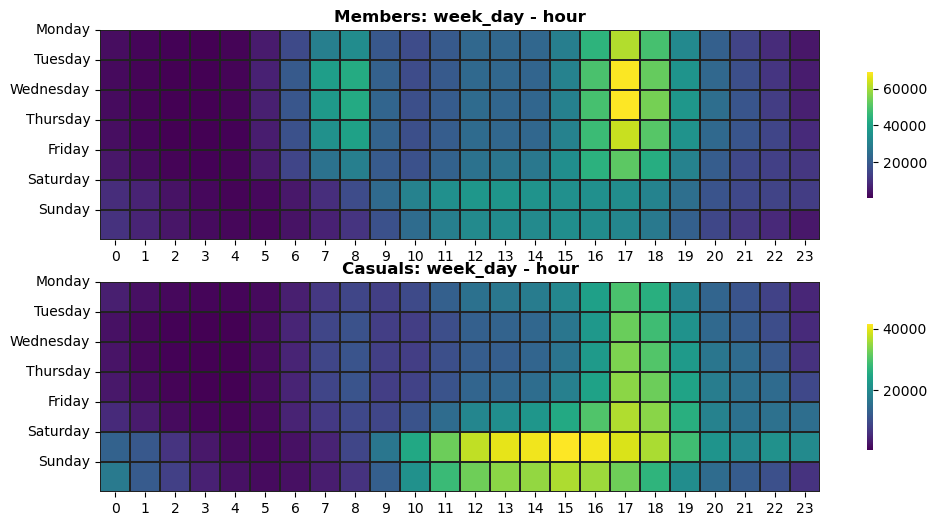

In [67]:
fig, axs = plt.subplots(figsize=(12, 6), nrows=2)
axs[0] = sns.heatmap(data_members, cmap="viridis",  # Choose a squential colormap
                     annot_kws={'fontsize': 11},  # Reduce size of label to fit
                     fmt='',          # Interpret labels as strings
                     cbar_kws={"shrink": 0.6},
                     square=True,     # Force square cells
                     linewidth=0.01,  # Add gridlines
                     linecolor="#222",
                     ax=axs[0])
axs[0].set_yticks(range(0, 7), ['Monday', 'Tuesday', 'Wednesday',
                                'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=0)
axs[0].set_title("Members: week_day - hour",
                 fontweight="bold")

axs[1] = sns.heatmap(data_casuals, cmap="viridis",  # Choose a squential colormap
                     annot_kws={'fontsize': 11},  # Reduce size of label to fit
                     fmt='',          # Interpret labels as strings
                     cbar_kws={"shrink": 0.6},
                     square=True,     # Force square cells
                     linewidth=0.01,  # Add gridlines
                     linecolor="#222",
                     ax=axs[1])
axs[1].set_yticks(range(0, 7), ['Monday', 'Tuesday', 'Wednesday',
                                'Thursday', 'Friday', 'Saturday', 'Sunday'], rotation=0)
axs[1].set_title("Casuals: week_day - hour",
                 fontweight="bold")

plt.savefig("../imgs/heatmap_wd-hour.png", transparent=True)
plt.show()

In [68]:
trips_time = df_trips_b1.groupby(["hour", "member_casual"]) \
    .agg({"start_station_name": 'size'}) \
    .rename(columns={'start_station_name': 'number_of_rides'}) \
    .reset_index()
trips_time

,hour,member_casual,number_of_rides
0,0,casual,47479
1,0,member,33173
2,1,casual,32821
3,1,member,20949
4,2,casual,19979
5,2,member,11473
6,3,casual,10635
7,3,member,6486
8,4,casual,7118
9,4,member,7125


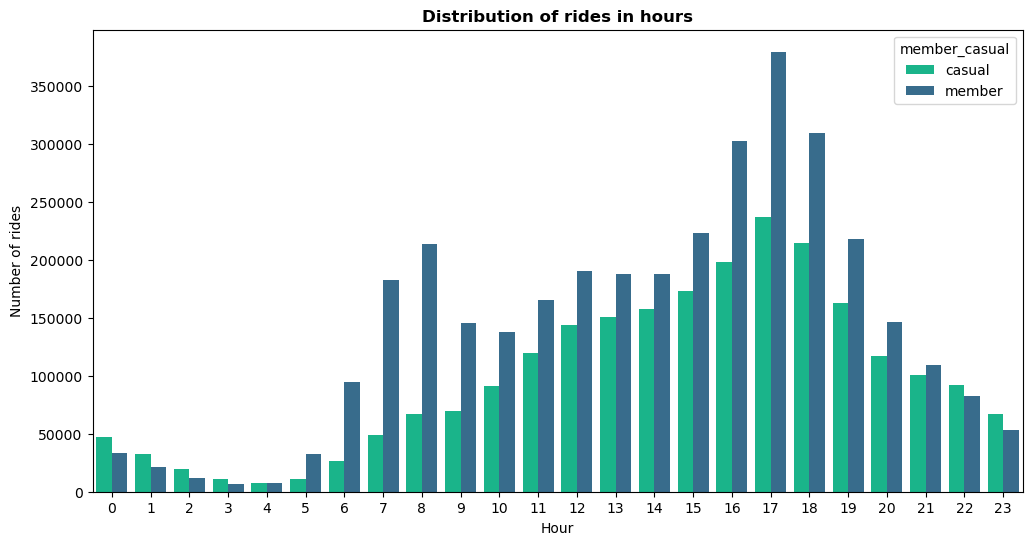

In [69]:
fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(data=trips_time,
            x="hour",
            y="number_of_rides",
            hue="member_casual",
            palette=["#00ce96", "#2a709a"])
ax.set_title("Distribution of rides in hours",
             fontweight="bold")
ax.set_xlabel("Hour")
ax.set_ylabel("Number of rides")

plt.savefig("../imgs/dstr_in_hours.png", transparent=True)

### Observations:
- There is a notice that most rides happens after work in working days.
- There is increase in ride for both groups during the day and decreases at night.
- There are noticeable increase in ride between 6am and 9am in the morning for members only and between 4pm and 7pm in the evening for both members and casual riders

a. Members

- **Highest** number of rides recorded at the ***16th***, ***17th*** and ***18th*** hour.
- **Lowest** number of rides recorded at the ***2nd***, ***3rd*** and ***4th*** hour.

b. Casual

- **Highest** number of rides recorded at the ***16th***, ***17th*** and ***18th*** hour.
- **Lowest** number of rides recorded at the ***3rd***, ***4th*** and ***5th*** hour.

### Interpretation 
- This trend support the previous speculation that members, most likely, use the service for work commute. 

## Answers
### 6.1. Conclusions
- Climatic conditions play a big role in influencing the number of rides across the year with a high number of rides recorded in warmer months.
- Classic bikes are the most preferred by both users.
- Months like Dec, Jan and Feb sees less amount of booking to increase it we can provide a discount on the booking to attract more customres.

### 1. How do annual members and casual riders use bikes differently?

- For the same ride length, it takes causal riders longer duration than members.

- Casual riders rides more on weekends while members do more on weekdays

- There are noticeable increase in ride between 6am and 9am in the morning for members only and between 4pm and 7pm in the evening for both members and casual riders

**&rarr;** Thus, based on above findings, it is safe to conclude that casual riders use the service mostly for leisure purpose, while members use them for routine activities such as exercising and daily commute to work.

### 2. Why would casual riders buy annual memberships?

- Considering the lifestyle of casual riders, buying more of fancy bikes would please more to their desire. It is obvious from their selection of docked bike over classic bike.

- Reducing annual membership compared to other option would also be attractive solution for them as most of them are probably youth(low income)

### 3. How can use digital media to influence casual riders to become members?

- Targeting social media, club houses and youth programs would be stragetic enough because casual riders are most likely to be found here

- The marketing team can offer free membership trial for a month in the beginning of spring. Casual riders may want to continue the membership if they find it convenient and cost-effetive than alternatives.

- Increased marketing of annual memberships towards start of warmer months.

- Adding incentives to weekend rides for annual membership holders.

- Allowing family or group registration should be allowed and encouraged especially for friends and families. It is assumed that casual riders are social and they would love to enjoy the discount that is attached to this as well and bring us new members.

- Awareness at popular start/end stations, season greeting and referral should be employed for constant and periodic reaching out.

 <a id = "eda2"></a>
# <b><span style='color:#4797ef'>|</span> EDA | II Investigate the GIS aspect of members and casuals</b>

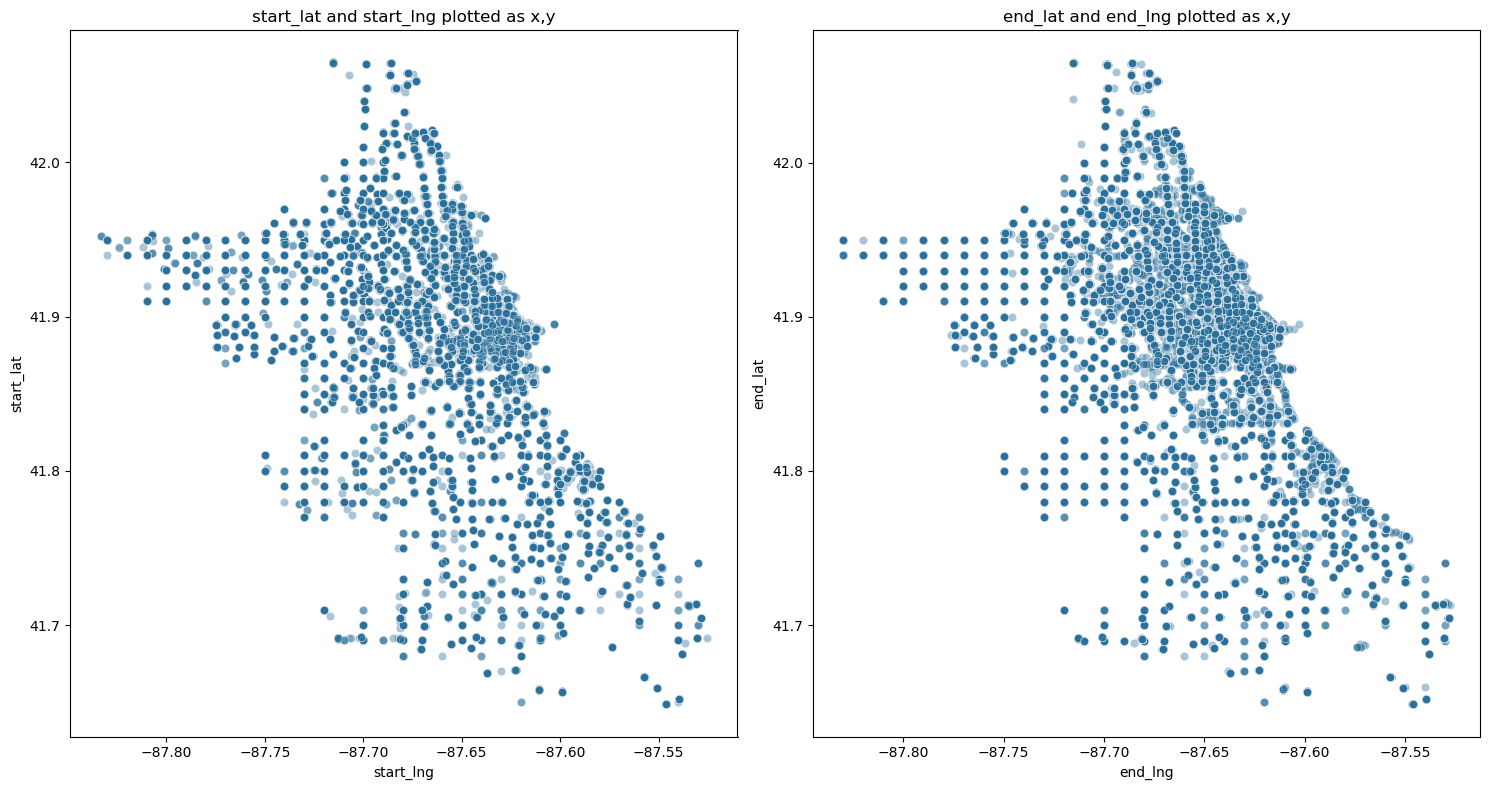

In [70]:
fig = plt.figure(figsize=(15, 8))

#  subplot #1
plt.subplot(1, 2, 1)
plt.title('start_lat and start_lng plotted as x,y')
sns.scatterplot(data=df_trips, y='start_lat',
                x='start_lng', alpha=0.4, color="#2a709a")

#  subplot #2
plt.subplot(1, 2, 2)
plt.title('end_lat and end_lng plotted as x,y')
sns.scatterplot(data=df_trips, y='end_lat',
                x='end_lng', alpha=0.4, color="#2a709a")

plt.tight_layout()
plt.show()

<AxesSubplot:title={'center':'boxplot of member and casual of end_lng'}, xlabel='member_casual', ylabel='end_lng'>

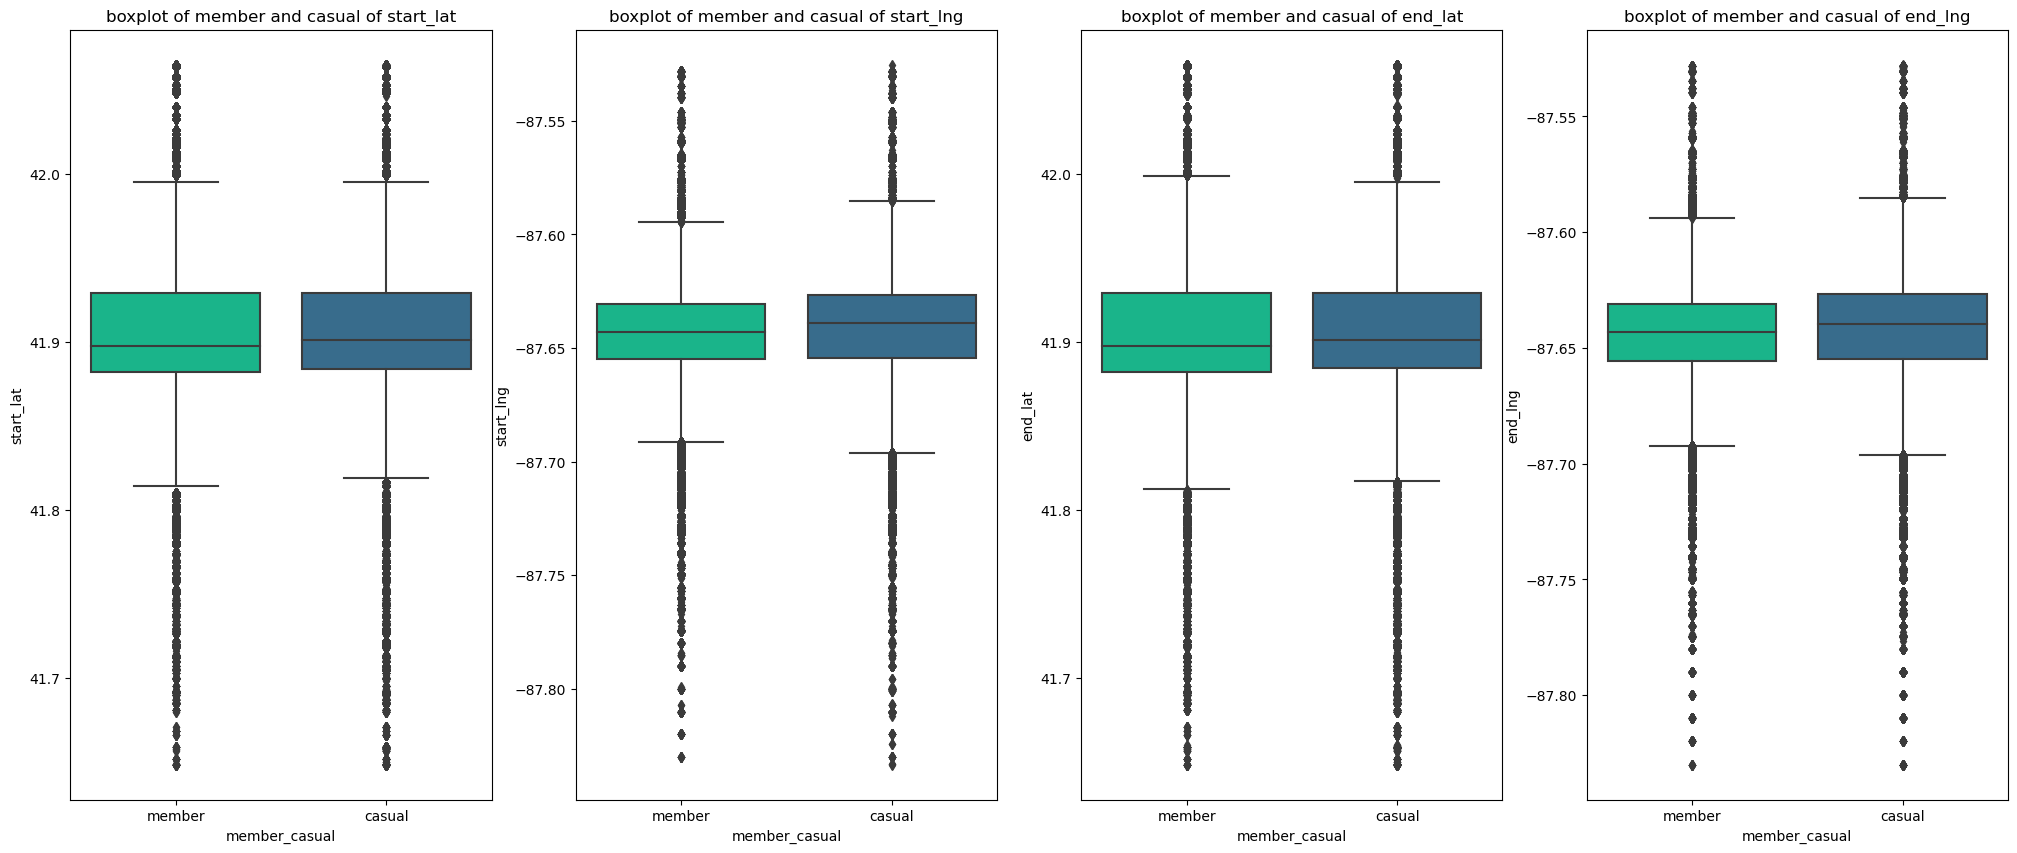

In [71]:
# looks at boxplot for the starting lat and long
fig = plt.figure(figsize=(25, 10))


plt.subplot(1, 4, 1)
plt.title('boxplot of member and casual of start_lat')
sns.boxplot(data=df_trips,
            x='member_casual',
            y="start_lat",
            palette=["#00ce96", "#2a709a"])

plt.subplot(1, 4, 2)
plt.title('boxplot of member and casual of start_lng')
sns.boxplot(data=df_trips,
            x='member_casual',
            y="start_lng",
            palette=["#00ce96", "#2a709a"])

plt.subplot(1, 4, 3)
plt.title('boxplot of member and casual of end_lat')
sns.boxplot(data=df_trips,
            x='member_casual',
            y="end_lat",
            color="#0183d1",
            palette=["#00ce96", "#2a709a"])

plt.subplot(1, 4, 4)
plt.title('boxplot of member and casual of end_lng')
sns.boxplot(data=df_trips,
            x='member_casual',
            y="end_lng",
            palette=["#00ce96", "#2a709a"])

Boxplots are more regular, although there are still statistical outliers (i.e. values below Q1–1.5 IQR and above Q3 + 1.5 IQR). If needed we can drop these later.

In [72]:
street_map = gpd.read_file(
    "../data/geo/geo_export_6cd99ec9-d172-4fb3-a9e4-f883438a16c6.shp")

In [73]:
member_locs = df_trips.loc[df_trips.member_casual.isin(['member'])]
casual_locs = df_trips.loc[df_trips.member_casual.isin(['casual'])]

In [74]:
def geo_df_creator(df, lat_col, lng_col, coord_sys):
    geometrys = [Point(xy) for xy in zip(df[lng_col], df[lat_col])]
    geo_df = gpd.GeoDataFrame(df, crs=coord_sys, geometry=geometrys)
    return geo_df


coord_sys = "WGS84"

geo_df_m_start = geo_df_creator(
    member_locs, 'start_lat', 'start_lng', coord_sys)
geo_df_c_start = geo_df_creator(
    casual_locs, 'start_lat', 'start_lng', coord_sys)

geo_df_m_end = geo_df_creator(member_locs, 'end_lat', 'end_lng', coord_sys)
geo_df_c_end = geo_df_creator(casual_locs, 'end_lat', 'end_lng', coord_sys)

In [75]:
df_trips[(df_trips['start_lat'] < 41.75) | (
    df_trips['start_lng'] < -87.75)]['member_casual'].value_counts()

casual    6563
member    3608
Name: member_casual, dtype: int64

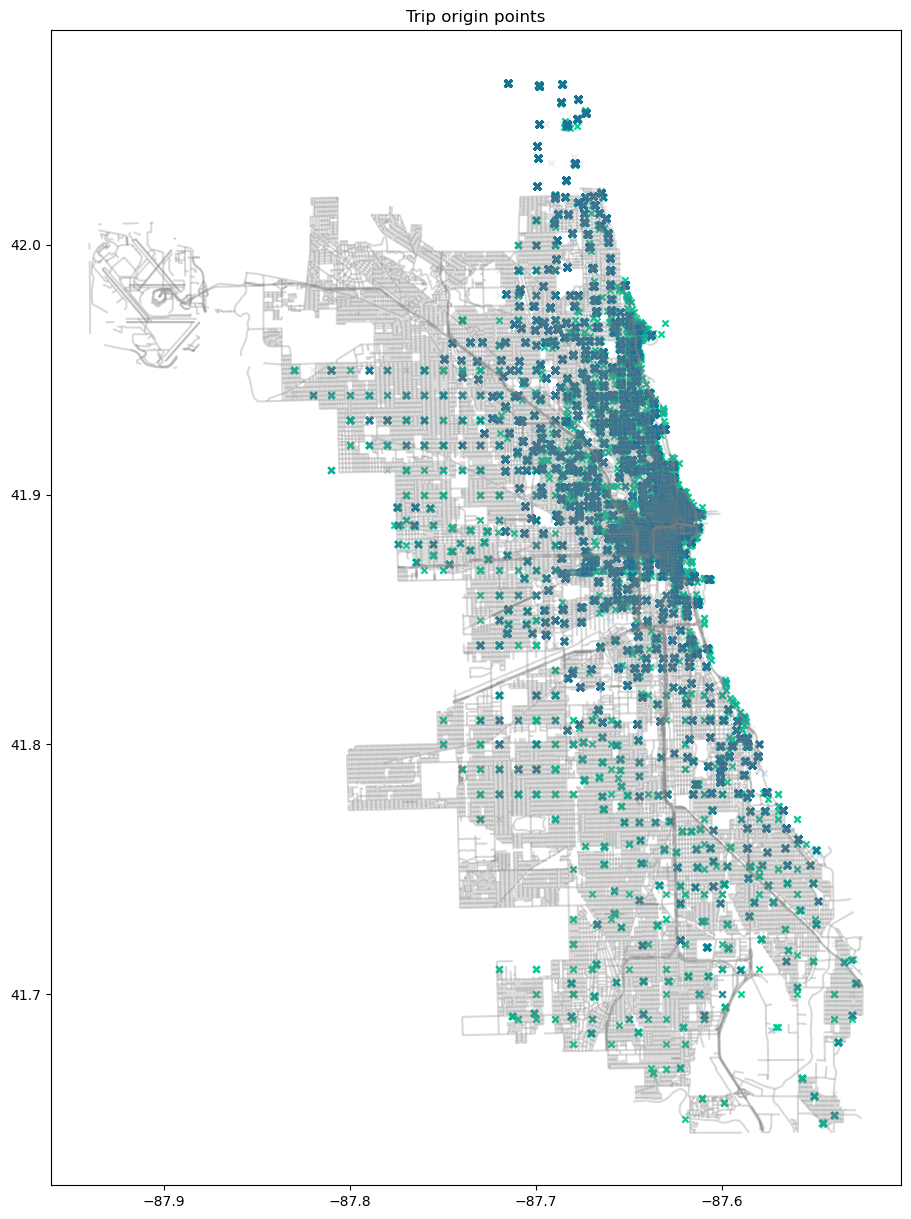

In [76]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.title('Trip origin points')

street_map.plot(ax=ax, alpha=0.3, color='grey')
geo_df_c_start.sample(frac=0.4).plot(ax=ax, markersize=20,
                                     color='#00ce96', marker='x', label="Casual")
geo_df_m_start.sample(frac=0.4).plot(ax=ax, markersize=20,
                                     color='#2a709a', alpha=0.1, marker='x', label="Member")

plt.savefig("../imgs/trip_points.png", transparent=True)

In [77]:
df_trips[(df_trips['end_lat'] < 41.75) | (
    df_trips['end_lng'] < -87.75)]['member_casual'].value_counts()

casual    6593
member    3638
Name: member_casual, dtype: int64

<AxesSubplot:title={'center':'Trip termination points'}>

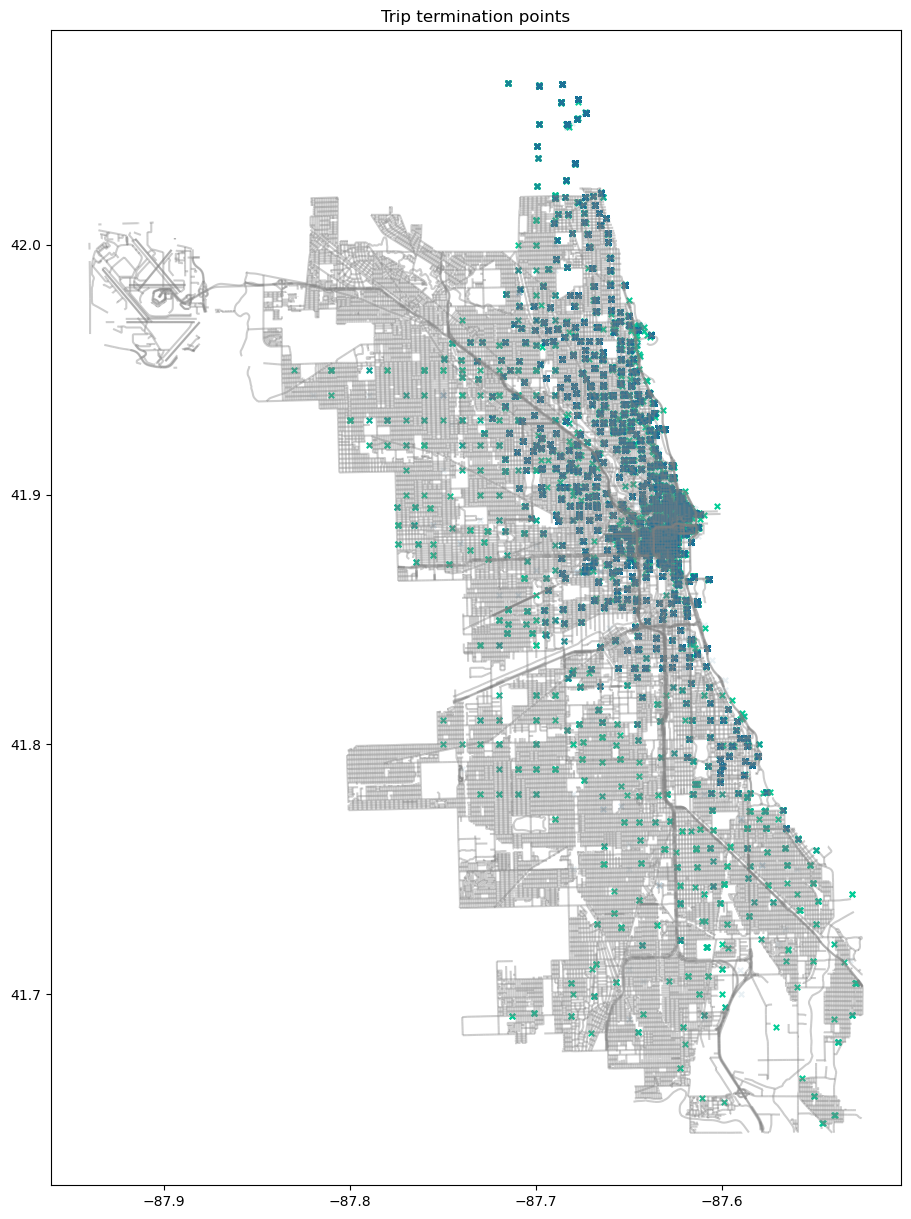

In [78]:
fig, ax = plt.subplots(figsize=(15, 15))
plt.title('Trip termination points')

street_map.plot(ax=ax, alpha=0.4, color='grey')
geo_df_c_end.sample(frac=0.05).plot(ax=ax, markersize=15,
                                    color='#00ce96', marker='x', label="Casual")
geo_df_m_end.sample(frac=0.05).plot(ax=ax, markersize=15,
                                    color='#2a709a', alpha=0.1, marker='x', label="Member")

## Observations:
- there are places where there have been no trips in all the time analyzed, so:  
  If we don't work in those areas, we can test  
  If we are working, it doesn't make sense to provide bike rentals there, and it leads to a loss of revenue.
- In the outlying areas the number of casual riders prevails

## Interpretation 
- Casual riders prefer to drive for pleasure and their free time

## Answers
 
### 1. What are the "hot"/"cold" spots of the city?
- From China Town to Rodgers Park(highlight on Map)
- 

### 2. Are the majority of routes intercommunity or intracommunity?
- In the outlying areas the number of regular drivers prevails, which again confirms
the fact that regulars prefer to drive for pleasure and their free time

 <a id = "eda3"></a>
# <b><span style='color:#4797ef'>|</span> Save data for modelling</b>

In [79]:
df_trips_b3 = df_trips.groupby(["FeelsLikeC", "maxtempC", "mintempC", "windspeedKmph", "cloudcover", "humidity", "pressure",
                                "visibility", "is_holiday", "is_weekend", "year", "season", "month", "hour", "day", "week_day"]) \
    .agg({"start_station_name": 'size'}) \
    .rename(columns={'start_station_name': 'number_of_rides'}) \
    .reset_index()
df_trips_b3.to_csv("../data/df_for_modelling.csv")

# <b><span style='color:#4797ef'>|</span> Make html</b>

In [1]:
!jupyter nbconvert --to html "EDA.ipynb"

[NbConvertApp] Converting notebook EDA.ipynb to html
[NbConvertApp] Writing 3483587 bytes to EDA.html
